## Experiment 1 
- Seeing which algorithm converges faster given a particular unitary size and given resolution 
- Resolution ranges from [10,50] with a changed of 5 in between 
- Max iterations is 10 and error threshold is $10^{-3}$

In [1]:
resolutions = [i for i in range(10, 55, 5)]
resolutions

[10, 15, 20, 25, 30, 35, 40, 45, 50]

In [2]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
import os
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
%matplotlib inline

# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-education')
# santiago = provider.get_backend('ibmq_santiago')
# casablanca = provider.get_backend('ibmq_casablanca')
# bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')
# athens = provider.get_backend('ibmq_athens')

In [3]:
from normal_SPEA import SPEA
from changed_SPEA import global_max_SPEA

### Utils

In [4]:
def generate_plots(unitary_size, costs, errors, overlaps, algorithm):
    import random
    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3 = random.sample(colors, 3)

    # plot
    os.makedirs("Experiment_1/"+str(unitary_size) +
                "_qubit(random)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost v/s Max iters", fontsize=16)
    ax1.set_xlabel("Number of Resolutions ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    ax1.plot(resolutions, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(resolutions, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % error v/s Max iters", fontsize=16)
    ax2.set_xlabel("Number of resolutions ", fontsize=15)
    ax2.set_ylabel("% error for nearest eigenvalue", fontsize=15)
    ax2.plot(resolutions, errors, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_1/"+str(unitary_size)+"_qubit(random)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

In [5]:
def get_results(eig_vals, eig_vect, bases, basis_indices, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_g = []
    max_overlaps_g = []
    # find how the cost converges with increasing iterations
    for reso in resolutions:
        costs = []
        errors = []
        overlaps = []
        i = 0
        # run the experiments ...
        while len(costs) < experiments:
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=reso, error=3, max_iters=10)
            else:
                spea = global_max_SPEA(
                    unitary, resolution=reso, error=3, max_iters=10)

            result = spea.get_eigen_pair(
                progress=False, backend=sim, algo='alternate', basis=bases[i], basis_ind=basis_indices[i],
                randomize=False,shots = 256)

            if result['cost'] < 0.65:
                continue
                
            # increment the basis index 
            i+=1  # in exp 1 -> basis[0], in exp 2 -> basis[1] and so on....
            
            # find the costs
            costs.append(result['cost'])
            theta = result['theta']
            res_state = result['state']

            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100
            errors.append(perc_error)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)
        
        print("Result with", reso, " resolutions :")
        print("AVG. COST :", np.average(costs),
              "AVG. ERROR :", np.average(errors))
        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_g.append(np.average(errors))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_g, max_overlaps_g

## 2 - qubit unitary


In [7]:
unit_2 = unitary_group.rvs(4)
unit_2

array([[ 0.17395249-0.88882475j, -0.04456424-0.00860066j,
        -0.01010367+0.15973123j, -0.01172507-0.38976599j],
       [-0.24574916-0.17806435j,  0.29339462+0.47761577j,
        -0.54189337-0.24944127j,  0.46398853+0.15016152j],
       [ 0.25601604+0.01672631j,  0.32138237+0.57278332j,
        -0.02811987+0.42146305j, -0.52698721+0.21603546j],
       [ 0.09645875+0.11181801j,  0.46887191+0.18037354j,
         0.32256347-0.57969427j, -0.15779222-0.5107112j ]])

In [8]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e)
print("Eigenstates :", eig_vect2)
print("Eigenvalues :", eig_vals2)

Eigenstates : [[ 0.91453814+0.j         -0.13274227+0.33061265j -0.17743543-0.01322607j
   0.06845642+0.01871384j]
 [ 0.05209689-0.1346549j  -0.24728887+0.05056376j  0.69375622+0.j
   0.20752891+0.62536354j]
 [ 0.09253807+0.09123316j  0.10887248-0.41826168j -0.13858477+0.4928665j
   0.73088579+0.j        ]
 [ 0.21440723+0.28269545j  0.7890312 +0.j          0.47350847-0.02665806j
  -0.07220813-0.14631355j]]
Eigenvalues : [0.7936645  0.63901816 0.04472861 0.2998451 ]


### Generate Basis set

In [9]:
bases2 , basis_indices2 = [], []
for _ in range(4):
    sample = unitary_group.rvs(4)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(4))
    bases2.append(basis)
    basis_indices2.append(ind)
print("Basis set :",bases2)
print("Basis indices :",basis_indices2)

Basis set : [[array([-0.08620796+0.29312123j, -0.62411264+0.41657174j,
       -0.29847551-0.31944893j,  0.31305775+0.23336481j]), array([-3.37017955e-04+0.5134577j ,  4.50515969e-01-0.05436888j,
        4.41091051e-01-0.36079658j,  4.26005348e-01+0.15564196j]), array([-0.04402445+0.79565459j, -0.04969675-0.17030454j,
       -0.19707869+0.25306763j, -0.46231567-0.1300123j ]), array([-0.05778943-0.06830234j,  0.42257705-0.14486554j,
       -0.60539745-0.12140819j, -0.09099755+0.63475287j])], [array([-0.10277104+0.14256121j, -0.41241897-0.30000734j,
       -0.07593458+0.78987397j,  0.13524651-0.24710734j]), array([ 0.12541622-0.25719687j, -0.51730575+0.2496443j ,
       -0.2469338 -0.35875005j,  0.3845406 -0.50064324j]), array([ 0.59383106+0.08980955j, -0.24248189-0.33158674j,
       -0.23475686-0.13255943j, -0.62544333-0.08178957j]), array([-0.71801752+0.10480797j, -0.45079514-0.19497484j,
       -0.0056208 -0.32854341j, -0.33221057+0.11789175j])], [array([ 0.24454732+0.46373699j, -0.137

### Algorithm 1

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.8857421875 AVG. ERROR : 5.697192203253564
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 15  resolutions :
AVG. COST : 0.908203125 AVG. ERROR : 7.762484340846199
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the es

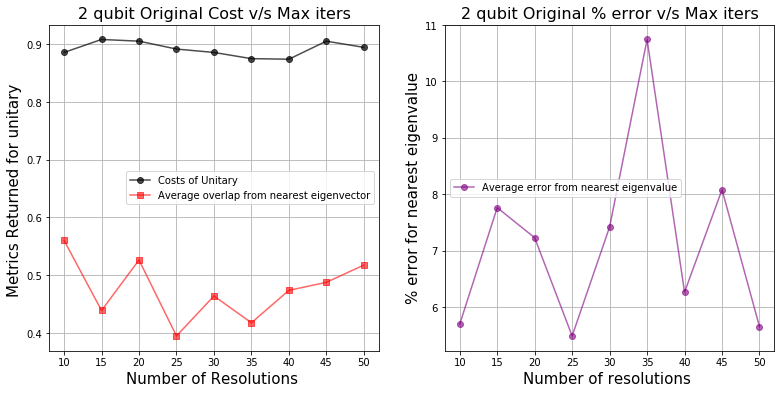

In [11]:
costs_2qubit_b, errors_eig_2qubit_b, max_overlaps_2qubit_b = get_results(
    eig_vals2, eig_vect2, bases2, basis_indices2, unit_2, 'original', 4)
generate_plots(2, costs_2qubit_b, errors_eig_2qubit_b,
               max_overlaps_2qubit_b, "Original")

### Algorithm 2

E:\ANACONDA\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.88671875 AVG. ERROR : 7.520748018283264
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 15  resolutions :
AVG. COST : 0.912109375 AVG. ERROR : 7.866944637079929
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the esti

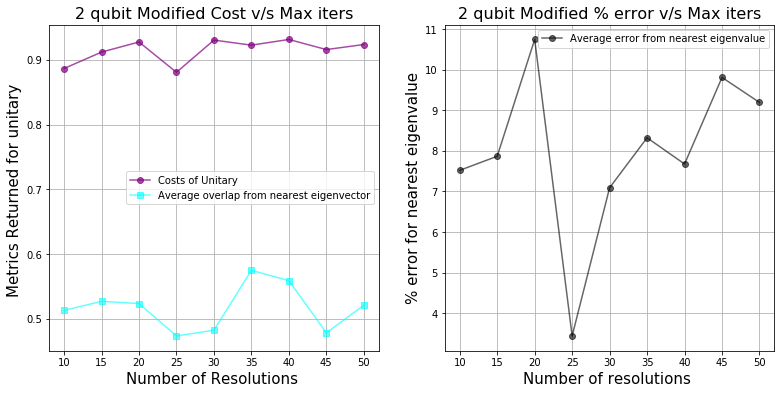

In [10]:
costs_2qubit_c, errors_eig_2qubit_c, max_overlaps_2qubit_c = get_results(
    eig_vals2, eig_vect2, bases2, basis_indices2, unit_2, 'modified', 4)
generate_plots(2, costs_2qubit_c, errors_eig_2qubit_c,
               max_overlaps_2qubit_c, "Modified")

## 3 - qubit unitary

In [12]:
unit_3 = unitary_group.rvs(8)
unit_3

array([[ 0.01986944+0.40080671j, -0.13451306+0.30236586j,
         0.09412125-0.19992745j,  0.18048968-0.17833929j,
         0.3238323 -0.44387977j,  0.06796569+0.01015198j,
         0.48186978-0.19403937j,  0.12045469+0.15890559j],
       [-0.30268855+0.29805147j,  0.09898766+0.19805249j,
        -0.3247824 +0.49482243j,  0.07727484-0.46040856j,
        -0.08776775-0.01523051j, -0.07184398-0.33741968j,
        -0.04641704+0.1742335j , -0.15505386-0.1368906j ],
       [ 0.19645232-0.04801718j,  0.21014414-0.39850183j,
        -0.42640771+0.29739887j,  0.08781663-0.05492343j,
         0.26452303-0.00133639j,  0.27389184+0.32178189j,
         0.17345743-0.21869065j, -0.29510074+0.24820663j],
       [-0.19045431-0.00105934j,  0.34075166+0.20881486j,
         0.28581492-0.2154113j ,  0.15093925-0.40844555j,
        -0.08044727+0.3180561j ,  0.280001  +0.17275048j,
        -0.24113146-0.04815035j, -0.02145868+0.45772265j],
       [-0.26319054+0.12436835j, -0.44981311-0.15159j   ,
        -0

In [13]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e)
print("Eigenstates :", eig_vect3)
print("Eigenvalues :", eig_vals3)

Eigenstates : [[-0.28247775-0.01023304j  0.20397979+0.08593119j -0.23889634+0.03014939j
   0.08047887+0.36056792j -0.24834367-0.05065381j  0.26073635-0.35531153j
  -0.37400953-0.3061456j  -0.27565773+0.32951117j]
 [ 0.57425461+0.j         -0.08548647-0.16723927j  0.07731297-0.05051217j
   0.30750632-0.08558218j -0.06644161-0.40439076j -0.03268563+0.14887226j
   0.03700525-0.32573415j -0.00757376+0.47522032j]
 [-0.04808274-0.11470185j  0.2007044 +0.01171094j -0.11922479-0.14533538j
   0.22936248+0.1727185j   0.67531115+0.j          0.27599558-0.04013443j
  -0.01871671-0.17586049j  0.51110632+0.j        ]
 [ 0.35475495+0.21991632j  0.66314435+0.j         -0.13806899-0.20271751j
   0.05781291-0.28560201j -0.20101212+0.26374226j  0.16012727+0.07617374j
  -0.08920736-0.10454916j -0.05109596-0.27937203j]
 [-0.28345419-0.24319936j  0.02750606-0.33406815j  0.04337384-0.12230029j
   0.55382728+0.j         -0.27088812+0.16441347j  0.13249705-0.067062j
   0.54347944+0.j         -0.05657865-0.0595

### Generate Basis

In [14]:
bases3 , basis_indices3 = [], []
for _ in range(4):
    sample = unitary_group.rvs(8)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(8))
    bases3.append(basis)
    basis_indices3.append(ind)
print("Basis set :",bases3)
print("Basis indices :",basis_indices3)

Basis set : [[array([-0.04872739+0.1775088j ,  0.1105142 +0.02716114j,
        0.22181966-0.14110616j,  0.26313122-0.57134654j,
       -0.05924674+0.09037525j,  0.35663265-0.14433604j,
       -0.21481025+0.50200495j, -0.16000672+0.07016526j]), array([-0.07690345+0.35677075j, -0.01361778+0.01590628j,
       -0.01198684+0.00407995j, -0.17109978+0.19662469j,
       -0.20012399-0.16619318j, -0.05825365+0.32517342j,
        0.08405602+0.52019231j,  0.2531741 -0.52886832j]), array([-0.02100155+0.38897674j,  0.10146536+0.33662264j,
       -0.40629244-0.01770542j,  0.32991613-0.27718566j,
        0.0738817 +0.14261045j, -0.50131913+0.23092961j,
        0.13953953-0.06880441j, -0.07540112+0.11509208j]), array([ 0.49797302+0.24394852j, -0.16530678+0.11464128j,
       -0.22000607-0.10223113j, -0.11329941+0.26557539j,
        0.38916942+0.24390144j,  0.05291809-0.17988502j,
       -0.4871115 +0.11937981j, -0.0626949 -0.09089894j]), array([ 0.00140027-0.01248547j, -0.31326463-0.06384472j,
        0

- Algorithm 1

In [ ]:
costs_3qubit_b, errors_eig_3qubit_b, max_overlaps_3qubit_b = get_results(
    eig_vals3, eig_vect3, bases3, basis_indices3, unit_3, 'original', 4)

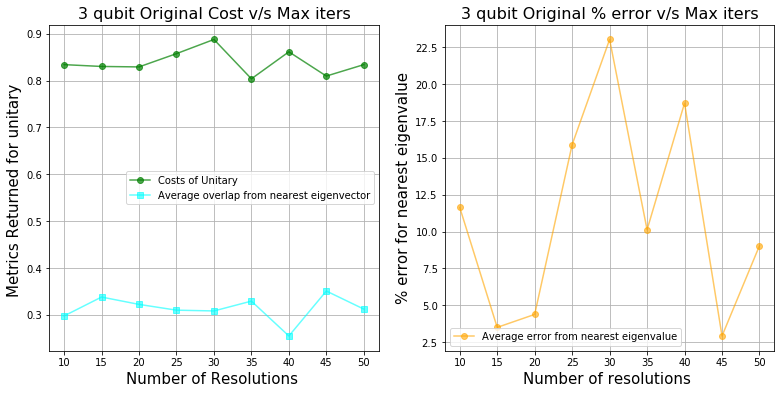

In [16]:
generate_plots(3, costs_3qubit_b, errors_eig_3qubit_b,
               max_overlaps_3qubit_b, "Original")

- Algorithm 2

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 10  resolutions :
AVG. COST : 0.875 AVG. ERROR : 15.290892456079114
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 15  resolutions :
AVG. COST : 0.84375 AVG. ERROR : 8.52115275641319
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
T

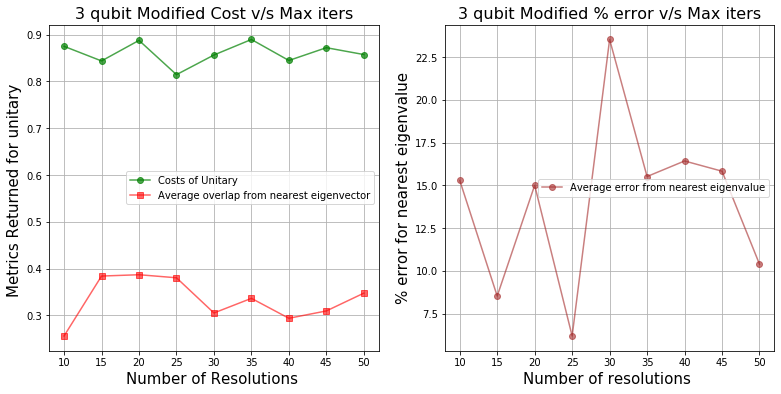

In [17]:
costs_3qubit_c, errors_eig_3qubit_c, max_overlaps_3qubit_c = get_results(
    eig_vals3, eig_vect3, bases3, basis_indices3, unit_3, 'modified', 4)
generate_plots(3, costs_3qubit_c, errors_eig_3qubit_c,
               max_overlaps_3qubit_c, "Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

In [ ]:
eig_vals4, eig_vect4 = np.linalg.eig(unit_4)
eig_vals4 = np.angle(eig_vals4)
e = []
for k in eig_vals4:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals4 = np.array(e)
print("Eigenstates :", eig_vect4)
print("Eigenvalues :", eig_vals4)

### Generate basis set

In [ ]:
bases4 , basis_indices4 = [], []
for _ in range(4):
    sample = unitary_group.rvs(16)
    basis = []
    for k in sample:
        basis.append(np.array(k, dtype=complex))
    ind = np.random.choice(range(16))
    bases4.append(basis)
    basis_indices4.append(ind)
print("Basis indices :",basis_indices4)

- Algorithm 1

In [ ]:
costs_4qubit_b, errors_eig_4qubit_b,  max_overlaps_4qubit_b = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'original', 4)
generate_plots(4, costs_4qubit_b, 
               errors_eig_4qubit_b, max_overlaps_4qubit_b,  "Original")

- Algorithm 2

In [ ]:
costs_4qubit_c, errors_eig_4qubit_c, max_overlaps_4qubit_c = get_results(
    eig_vals4, eig_vect4, bases4, basis_indices4, unit_4, 'modified', 4)
generate_plots(4, costs_4qubit_c, 
               errors_eig_4qubit_c,max_overlaps_4qubit_c, "Modified")